In [1]:
import os
import numpy as np
from sklearn.metrics import roc_auc_score

# === Dequantization helper ===
def dequantize_from_uint16(q, x_min, x_max):
    """Dequantizes a uint16 array to float64 using stored min/max."""
    return x_min + (q.astype(np.float64) / 65535.0) * (x_max - x_min)

# === Paths ===
your_base = "/n/groups/patel/adithya/UKB_Ratios/ukb_ratios/results/protein_ratios_alone/individual_results"
randy_base = "/n/groups/patel/randy/intl_congress_peer_review_2025/results/proteins_alone/individual_results"

n_outcomes = 607  # total number of disease outcomes
folds = range(5)

def all_folds_exist(base, outcome, folds):
    """Check if all 5 folds exist for this outcome."""
    return all(os.path.exists(os.path.join(base, f"outcome_{outcome}", f"fold_{fold}", "test_labels_predictions.npz"))
               for fold in folds)

def get_mean_auc(base, outcome, folds):
    aucs = []
    for fold in folds:
        path = os.path.join(base, f"outcome_{outcome}", f"fold_{fold}", "test_labels_predictions.npz")
        d = np.load(path)

        y_true = d["q_true"]
        y_pred = d["q_pred"]

        # === FIX: Dequantize if stored as uint16 ===
        if y_pred.dtype == np.uint16:
            y_pred = dequantize_from_uint16(y_pred, float(d["pred_min"]), float(d["pred_max"]))
        else:
            y_pred = y_pred.astype(float)

        if y_true.dtype == np.uint16:
            y_true = dequantize_from_uint16(y_true, float(d["true_min"]), float(d["true_max"]))
        else:
            y_true = y_true.astype(float)

        if len(np.unique(y_true)) < 2:  # skip degenerate folds
            continue
        aucs.append(roc_auc_score(y_true, y_pred))
    return np.mean(aucs) if aucs else np.nan

ratios_better = 0
raw_better = 0
equal = 0
valid = 0

for outcome in range(n_outcomes):
    # Skip outcomes missing any folds for either experiment
    if not (all_folds_exist(your_base, outcome, folds) and all_folds_exist(randy_base, outcome, folds)):
        continue

    auc_ratios = get_mean_auc(your_base, outcome, folds)
    auc_raw = get_mean_auc(randy_base, outcome, folds)
    if np.isnan(auc_ratios) or np.isnan(auc_raw):
        continue

    valid += 1
    if auc_ratios > auc_raw:
        ratios_better += 1
    elif auc_raw > auc_ratios:
        raw_better += 1
    else:
        equal += 1

if valid == 0:
    print("No valid outcomes found — likely due to missing folds or degenerate labels.")
else:
    print(f"Total outcomes with 5 folds in both: {valid}")
    print(f"Ratios better: {ratios_better} ({ratios_better/valid*100:.1f}%)")
    print(f"Raw better: {raw_better} ({raw_better/valid*100:.1f}%)")
    print(f"Equal: {equal} ({equal/valid*100:.1f}%)")

Total outcomes with 5 folds in both: 587
Ratios better: 558 (95.1%)
Raw better: 29 (4.9%)
Equal: 0 (0.0%)


In [2]:
import os, math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# === Dequantization helper ===
def dequantize_from_uint16(q, x_min, x_max):
    return x_min + (q.astype(np.float64) / 65535.0) * (x_max - x_min)

# === Paths ===
your_base = "/n/groups/patel/adithya/UKB_Ratios/ukb_ratios/results/protein_ratios_alone/individual_results"
randy_base = "/n/groups/patel/randy/intl_congress_peer_review_2025/results/proteins_alone/individual_results"

n_outcomes = 607
folds = range(5)

def all_folds_exist(base, outcome, folds):
    return all(os.path.exists(os.path.join(base, f"outcome_{outcome}", f"fold_{fold}", "test_labels_predictions.npz"))
               for fold in folds)

def get_mean_auc(base, outcome, folds):
    aucs = []
    for fold in folds:
        path = os.path.join(base, f"outcome_{outcome}", f"fold_{fold}", "test_labels_predictions.npz")
        d = np.load(path)

        y_true = d["q_true"]
        y_pred = d["q_pred"]

        if y_pred.dtype == np.uint16:
            y_pred = dequantize_from_uint16(y_pred, float(d["pred_min"]), float(d["pred_max"]))
        else:
            y_pred = y_pred.astype(float)

        if y_true.dtype == np.uint16:
            y_true = dequantize_from_uint16(y_true, float(d["true_min"]), float(d["true_max"]))
        else:
            y_true = y_true.astype(float)

        if len(np.unique(y_true)) < 2:
            continue

        aucs.append(roc_auc_score(y_true, y_pred))
    return np.mean(aucs) if aucs else np.nan

# --- Collect absolute and relative changes ---
abs_diffs = []   # ΔAUC = ratios - raw
pct_diffs = []   # %ΔAUC relative to raw = 100 * ΔAUC / raw

valid = 0
for outcome in range(n_outcomes):
    if not (all_folds_exist(your_base, outcome, folds) and all_folds_exist(randy_base, outcome, folds)):
        continue

    auc_ratios = get_mean_auc(your_base, outcome, folds)
    auc_raw = get_mean_auc(randy_base, outcome, folds)
    if np.isnan(auc_ratios) or np.isnan(auc_raw):
        continue

    valid += 1
    delta = auc_ratios - auc_raw
    abs_diffs.append(delta)

    # Guard against division by ~0 (shouldn't happen with AUC, but be safe)
    if not np.isclose(auc_raw, 0.0):
        pct_diffs.append(100.0 * delta / auc_raw)
    else:
        pct_diffs.append(np.nan)

abs_diffs = np.array([x for x in abs_diffs if not np.isnan(x)])
pct_diffs = np.array([x for x in pct_diffs if not np.isnan(x)])

print(f"Collected outcomes: {len(abs_diffs)}")

# --- Summary: mean/median as %; min/max/range as absolute ΔAUC ---
if len(abs_diffs) > 0:
    mean_pct = np.mean(pct_diffs)
    median_pct = np.median(pct_diffs)
    min_abs = np.min(abs_diffs)
    max_abs = np.max(abs_diffs)
    range_abs = max_abs - min_abs

    print("\n--- ΔAUC Summary ---")
    print(f"Mean % improvement:   {mean_pct:.2f}%")
    print(f"Median % improvement: {median_pct:.2f}%")
    print(f"Min absolute ΔAUC:    {min_abs:.4f}")
    print(f"Max absolute ΔAUC:    {max_abs:.4f}")
    print(f"Range (abs ΔAUC):     {range_abs:.4f}")
else:
    print("No ΔAUC values found to summarize.")

Collected outcomes: 587

--- ΔAUC Summary ---
Mean % improvement:   7.93%
Median % improvement: 5.05%
Min absolute ΔAUC:    -0.0959
Max absolute ΔAUC:    0.2417
Range (abs ΔAUC):     0.3376


In [3]:
if len(abs_diffs) > 0:
    mean_pct = np.mean(pct_diffs)
    median_pct = np.median(pct_diffs)
    min_abs = np.min(abs_diffs)
    max_abs = np.max(abs_diffs)
    range_abs = max_abs - min_abs

    max_pct = np.max(pct_diffs)

    print("\n--- ΔAUC Summary ---")
    print(f"Mean % improvement:    {mean_pct:.2f}%")
    print(f"Median % improvement:  {median_pct:.2f}%")
    print(f"Max % improvement:     {max_pct:.2f}%")
    print(f"Min absolute ΔAUC:     {min_abs:.4f}")
    print(f"Max absolute ΔAUC:     {max_abs:.4f}")
    print(f"Range (abs ΔAUC):      {range_abs:.4f}")
else:
    print("No ΔAUC values found to summarize.")


--- ΔAUC Summary ---
Mean % improvement:    7.93%
Median % improvement:  5.05%
Max % improvement:     46.46%
Min absolute ΔAUC:     -0.0959
Max absolute ΔAUC:     0.2417
Range (abs ΔAUC):      0.3376


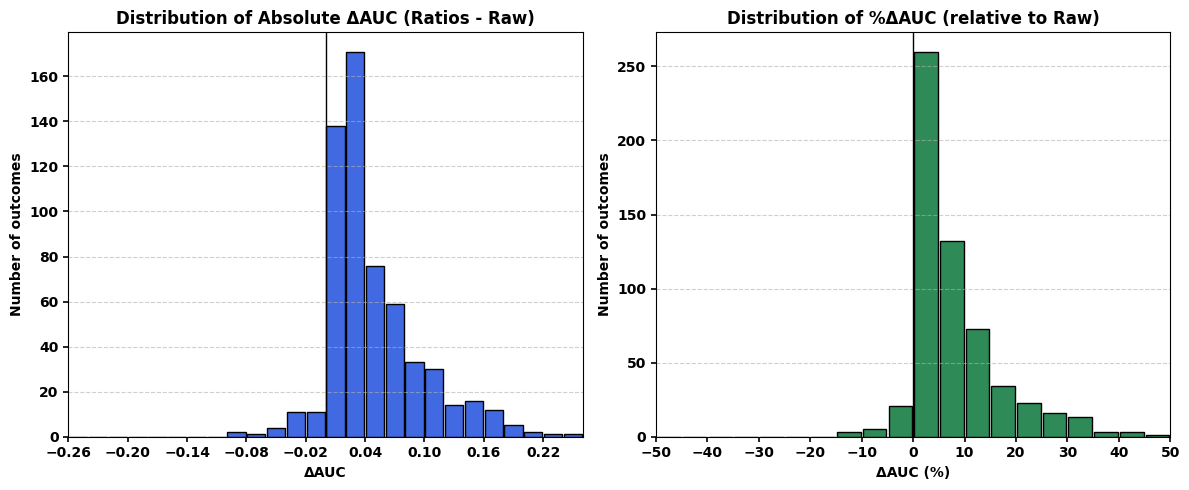

In [11]:
# remake to just be the percentage plot

def nice_step(max_abs, candidates):
    for s in candidates:
        bins = 2 * math.ceil(max_abs / s)
        if bins <= 40:
            return s
    return candidates[-1]

def make_hist_bars(ax, data, color, title, xlabel):
    x = np.asarray(data)
    if len(x) == 0:
        ax.text(0.5, 0.5, "No data", ha="center", va="center", fontsize=12)
        ax.axis("off")
        return

    max_abs = np.max(np.abs(x))
    if max_abs == 0:
        max_abs = 1e-3

    # Choose step sizes for absolute vs percent plots by label
    if "%" in xlabel:
        candidates = [0.1, 0.2, 0.5, 1.0, 2.0, 5.0]
    else:
        candidates = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05]

    step = nice_step(max_abs, candidates)
    limit = step * math.ceil(max_abs / step)
    edges = np.arange(-limit, limit + step, step)
    counts, edges = np.histogram(x, bins=edges)
    centers = (edges[:-1] + edges[1:]) / 2.0
    width = step * 0.92

    ax.bar(centers, counts, width=width, color=color, edgecolor="black")
    ax.axvline(0, color="black", linewidth=1)

    # === BOLD TITLE AND AXIS LABELS ===
    ax.set_title(title, fontweight="bold")
    ax.set_xlabel(xlabel, fontweight="bold")
    ax.set_ylabel("Number of outcomes", fontweight="bold")

    # === BOLD TICK LABELS ===
    ax.tick_params(axis="x", labelsize=10, width=1.2)
    ax.tick_params(axis="y", labelsize=10, width=1.2)
    for tick in ax.get_xticklabels():
        tick.set_fontweight("bold")
    for tick in ax.get_yticklabels():
        tick.set_fontweight("bold")

    ax.set_xlim(-limit, limit)
    ax.grid(axis="y", linestyle="--", alpha=0.6)

    tick_step = step * max(1, math.ceil((2 * limit / step) / 10))
    ticks = np.arange(-limit, limit + 1e-12, tick_step)
    ax.set_xticks(ticks)

# --- Plot both histograms side by side ---
if len(abs_diffs) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    make_hist_bars(
        axes[0], abs_diffs, color="royalblue",
        title="Distribution of Absolute ΔAUC (Ratios - Raw)",
        xlabel="ΔAUC"
    )
    make_hist_bars(
        axes[1], pct_diffs, color="seagreen",
        title="Distribution of %ΔAUC (relative to Raw)",
        xlabel="ΔAUC (%)"
    )

    plt.tight_layout()
    plt.show()
else:
    print("No ΔAUC values found to plot.")

In [5]:
import os
import numpy as np
from sklearn.metrics import roc_auc_score
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests

# === Dequantization helper ===
def dequantize_from_uint16(q, x_min, x_max):
    """Dequantizes a uint16 array to float64 using stored min/max."""
    return x_min + (q.astype(np.float64) / 65535.0) * (x_max - x_min)

# === Paths ===
your_base = "/n/groups/patel/adithya/UKB_Ratios/ukb_ratios/results/protein_ratios_alone/individual_results"
randy_base = "/n/groups/patel/randy/intl_congress_peer_review_2025/results/proteins_alone/individual_results"

n_outcomes = 607
folds = range(5)

def all_folds_exist(base, outcome, folds):
    """Check if all 5 folds exist for this outcome."""
    return all(os.path.exists(os.path.join(base, f"outcome_{outcome}", f"fold_{fold}", "test_labels_predictions.npz"))
               for fold in folds)

def get_fold_aucs(base, outcome, folds):
    """Return an array of per-fold AUCs (after dequantization)."""
    aucs = []
    for fold in folds:
        path = os.path.join(base, f"outcome_{outcome}", f"fold_{fold}", "test_labels_predictions.npz")
        if not os.path.exists(path):
            continue
        d = np.load(path)
        y_true, y_pred = d["q_true"], d["q_pred"]

        # --- Dequantize if needed ---
        if y_pred.dtype == np.uint16:
            y_pred = dequantize_from_uint16(y_pred, float(d["pred_min"]), float(d["pred_max"]))
        else:
            y_pred = y_pred.astype(float)

        if y_true.dtype == np.uint16:
            y_true = dequantize_from_uint16(y_true, float(d["true_min"]), float(d["true_max"]))
        else:
            y_true = y_true.astype(float)

        # --- Ensure binary labels ---
        if not np.array_equal(np.unique(y_true), [0.0, 1.0]):
            y_true = np.where(y_true > 0.5, 1.0, 0.0)

        if len(np.unique(y_true)) < 2:
            continue  # skip degenerate folds

        aucs.append(roc_auc_score(y_true, y_pred))
    return np.array(aucs)

# === Collect per-outcome stats ===
pvals = []
ratios_better_flags = []
valid_outcomes = []

for outcome in range(n_outcomes):
    if not (all_folds_exist(your_base, outcome, folds) and all_folds_exist(randy_base, outcome, folds)):
        continue

    auc_ratios = get_fold_aucs(your_base, outcome, folds)
    auc_raw = get_fold_aucs(randy_base, outcome, folds)
    if len(auc_ratios) < 2 or len(auc_raw) < 2:
        continue

    # Align folds
    n = min(len(auc_ratios), len(auc_raw))
    auc_ratios, auc_raw = auc_ratios[:n], auc_raw[:n]

    mean_ratios, mean_raw = np.mean(auc_ratios), np.mean(auc_raw)
    if np.isnan(mean_ratios) or np.isnan(mean_raw):
        continue

    # --- Paired t-test ---
    t_stat, pval = ttest_rel(auc_ratios, auc_raw, nan_policy='omit')
    pvals.append(pval)
    ratios_better_flags.append(mean_ratios > mean_raw)
    valid_outcomes.append(outcome)

# === Summaries + FDR ===
if not pvals:
    print("No valid outcomes found — likely due to missing folds or degenerate labels.")
else:
    reject, pvals_adj, _, _ = multipletests(pvals, alpha=0.05, method="fdr_bh")
    significant_better = sum(reject & np.array(ratios_better_flags))
    significant_worse = sum(reject & ~np.array(ratios_better_flags))
    total_sig = sum(reject)

    print(f"Total valid outcomes: {len(valid_outcomes)}")
    print(f"Significant improvements (ratios > raw, FDR < 0.05): {significant_better} ({significant_better/len(valid_outcomes)*100:.1f}%)")
    print(f"Significant declines (ratios < raw, FDR < 0.05): {significant_worse} ({significant_worse/len(valid_outcomes)*100:.1f}%)")
    print(f"Non-significant differences: {len(valid_outcomes) - total_sig} "
          f"({(len(valid_outcomes)-total_sig)/len(valid_outcomes)*100:.1f}%)")

Total valid outcomes: 587
Significant improvements (ratios > raw, FDR < 0.05): 333 (56.7%)
Significant declines (ratios < raw, FDR < 0.05): 4 (0.7%)
Non-significant differences: 250 (42.6%)


In [6]:
import os
import numpy as np
import pandas as pd
import re
from sklearn.metrics import roc_auc_score
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests

# ================================================================
# Dequantization
# ================================================================
def dequantize_from_uint16(q, x_min, x_max):
    return x_min + (q.astype(np.float64) / 65535.0) * (x_max - x_min)


# ================================================================
# Paths
# ================================================================
your_base  = "/n/groups/patel/adithya/UKB_Ratios/ukb_ratios/results/protein_ratios_alone/individual_results"
randy_base = "/n/groups/patel/randy/intl_congress_peer_review_2025/results/proteins_alone/individual_results"

outcome_meta_path = "/n/groups/patel/randy/rfb/tidy_data/UKBiobank/all_outcomes"
fieldmap_path     = "/home/adm808/ukb_ratios_folder/field.txt"

n_outcomes = 607
folds = range(5)


# ================================================================
# Load metadata
# ================================================================
df_outcomes = pd.read_parquet(
    f"{outcome_meta_path}/proteomics_first_occurrences.parquet",
    engine="pyarrow"
)

outcomes_list = pd.read_csv(
    f"{outcome_meta_path}/outcome_colnames.txt",
    header=None
)[0].tolist()

fields = pd.read_csv(fieldmap_path, sep="\t", dtype=str)


# ================================================================
# Helper: check all folds exist
# ================================================================
def all_folds_exist(base, outcome):
    return all(
        os.path.exists(
            os.path.join(base, f"outcome_{outcome}", f"fold_{fold}", "test_labels_predictions.npz")
        ) for fold in folds
    )


# ================================================================
# Helper: load AUCs for each fold
# ================================================================
def get_fold_aucs(base, outcome):
    aucs = []
    for fold in folds:
        path = os.path.join(base, f"outcome_{outcome}", f"fold_{fold}", "test_labels_predictions.npz")
        if not os.path.exists(path):
            continue

        d = np.load(path)
        y_true, y_pred = d["q_true"], d["q_pred"]

        # Dequantize preds
        if y_pred.dtype == np.uint16:
            y_pred = dequantize_from_uint16(
                y_pred, float(d["pred_min"]), float(d["pred_max"])
            )
        else:
            y_pred = y_pred.astype(float)

        # Dequantize labels
        if y_true.dtype == np.uint16:
            y_true = dequantize_from_uint16(
                y_true, float(d["true_min"]), float(d["true_max"])
            )
        else:
            y_true = y_true.astype(float)

        # Force binary
        if not np.array_equal(np.unique(y_true), [0.0, 1.0]):
            y_true = np.where(y_true > 0.5, 1.0, 0.0)

        # Skip degenerate fold
        if len(np.unique(y_true)) < 2:
            continue

        aucs.append(roc_auc_score(y_true, y_pred))

    return np.array(aucs)


# ================================================================
# Run paired t-tests
# ================================================================
pvals = []
ratios_better_flags = []
valid_outcomes = []

for outcome in range(n_outcomes):

    # Must exist in both pipelines
    if not (all_folds_exist(your_base, outcome) and all_folds_exist(randy_base, outcome)):
        continue

    auc_ratios = get_fold_aucs(your_base, outcome)
    auc_raw    = get_fold_aucs(randy_base, outcome)

    if len(auc_ratios) < 2 or len(auc_raw) < 2:
        continue

    # Align folds
    n = min(len(auc_ratios), len(auc_raw))
    auc_ratios, auc_raw = auc_ratios[:n], auc_raw[:n]

    if np.isnan(auc_ratios).any() or np.isnan(auc_raw).any():
        continue

    # Paired test
    _, pval = ttest_rel(auc_ratios, auc_raw, nan_policy="omit")
    pvals.append(pval)
    ratios_better_flags.append(np.mean(auc_ratios) > np.mean(auc_raw))
    valid_outcomes.append(outcome)


pvals = np.array(pvals)
ratios_better_flags = np.array(ratios_better_flags)
valid_outcomes = np.array(valid_outcomes)

reject, pvals_adj, _, _ = multipletests(pvals, alpha=0.05, method="fdr_bh")

print(f"Valid outcomes: {len(valid_outcomes)}")
print(f"Significant improvements: {np.sum(reject & ratios_better_flags)}")
print(f"Significant declines: {np.sum(reject & ~ratios_better_flags)}")
print(f"Non-significant: {len(valid_outcomes) - np.sum(reject)}")


# ================================================================
#              MAP SIGNIFICANT OUTCOMES → DISEASE NAMES
# ================================================================
sig_outcomes = valid_outcomes[reject & ratios_better_flags]

mapped_names = []

for outcome in sig_outcomes:
    if outcome >= len(outcomes_list):
        continue

    raw_col = outcomes_list[outcome]        # e.g. "131888-0.0"
    field_id = raw_col.split("-")[0]        # e.g. "131888"

    # lookup field_id in field.txt
    match = fields.loc[fields["field_id"] == field_id]

    if not match.empty:
        disease_name = match.iloc[0]["title"]
    else:
        disease_name = f"UNKNOWN_FIELD_{field_id}"

    # Strip prefix "Date XXX first reported (...)"
    disease_name = re.sub(r"^Date.*first reported\s*", "", disease_name).strip()

    mapped_names.append(disease_name)


print("\n=== CLEAN DISEASE NAMES WITH SIGNIFICANT IMPROVEMENT ===")
for name in mapped_names:
    print(name)

Valid outcomes: 587
Significant improvements: 333
Significant declines: 4
Non-significant: 250

=== CLEAN DISEASE NAMES WITH SIGNIFICANT IMPROVEMENT ===
(other salmonella infections)
(other protozoal intestinal diseases)
(respiratory tuberculosis, bacteriologically and histologically confirmed)
(respiratory tuberculosis, not confirmed bacteriologically or histologically)
(scarlet fever)
(other septicaemia)
(bacterial infection of unspecified site)
(acute poliomyelitis)
(viral meningitis)
(varicella [chickenpox])
(measles)
(rubella [german measles])
(viral warts)
(other viral infections characterised by skin and mucous membrane lesions, not elsewhere classified)
(acute hepatitis a)
(acute hepatitis b)
(infectious mononucleosis)
(viral infection of unspecified site)
(dermatophytosis)
(aspergillosis)
(unspecified mycosis)
(enterobiasis)
(scabies)
(other bacterial agents as the cause of diseases classified to other chapters)
(viral agents as the cause of diseases classified to other chapte

In [7]:
import os
import numpy as np
import pandas as pd
import re
from sklearn.metrics import roc_auc_score
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests

# ================================================================
# Dequantization
# ================================================================
def dequantize_from_uint16(q, x_min, x_max):
    return x_min + (q.astype(np.float64) / 65535.0) * (x_max - x_min)

# ================================================================
# Paths
# ================================================================
your_base  = "/n/groups/patel/adithya/UKB_Ratios/ukb_ratios/results/protein_ratios_alone/individual_results"
randy_base = "/n/groups/patel/randy/intl_congress_peer_review_2025/results/proteins_alone/individual_results"

n_outcomes = 607
folds = range(5)

def all_folds_exist(base, outcome, folds):
    return all(os.path.exists(os.path.join(base, f"outcome_{outcome}", f"fold_{fold}", "test_labels_predictions.npz"))
               for fold in folds)

def get_fold_aucs(base, outcome, folds):
    aucs = []
    for fold in folds:
        path = os.path.join(base, f"outcome_{outcome}", f"fold_{fold}", "test_labels_predictions.npz")
        if not os.path.exists(path):
            continue

        d = np.load(path)
        y_true, y_pred = d["q_true"], d["q_pred"]

        # Dequantize preds
        if y_pred.dtype == np.uint16:
            y_pred = dequantize_from_uint16(y_pred, float(d["pred_min"]), float(d["pred_max"]))
        else:
            y_pred = y_pred.astype(float)

        # Dequantize labels
        if y_true.dtype == np.uint16:
            y_true = dequantize_from_uint16(y_true, float(d["true_min"]), float(d["true_max"]))
        else:
            y_true = y_true.astype(float)

        # Force binary
        if not np.array_equal(np.unique(y_true), [0.0, 1.0]):
            y_true = np.where(y_true > 0.5, 1.0, 0.0)

        # Skip degenerate fold
        if len(np.unique(y_true)) < 2:
            continue

        aucs.append(roc_auc_score(y_true, y_pred))

    return np.array(aucs)


# ================================================================
# Run paired t-tests across all outcomes
# ================================================================
pvals = []
ratios_better_flags = []
valid_outcomes = []

for outcome in range(n_outcomes):

    # Ensure both your and Randy’s folds exist
    if not (all_folds_exist(your_base, outcome, folds) and
            all_folds_exist(randy_base, outcome, folds)):
        continue

    auc_ratios = get_fold_aucs(your_base, outcome, folds)
    auc_raw    = get_fold_aucs(randy_base, outcome, folds)

    if len(auc_ratios) < 2 or len(auc_raw) < 2:
        continue

    # Align folds
    n = min(len(auc_ratios), len(auc_raw))
    auc_ratios, auc_raw = auc_ratios[:n], auc_raw[:n]

    if np.isnan(auc_ratios).any() or np.isnan(auc_raw).any():
        continue

    # Paired t-test
    t_stat, pval = ttest_rel(auc_ratios, auc_raw, nan_policy="omit")
    pvals.append(pval)
    ratios_better_flags.append(np.mean(auc_ratios) > np.mean(auc_raw))
    valid_outcomes.append(outcome)

pvals = np.array(pvals)
ratios_better_flags = np.array(ratios_better_flags)
valid_outcomes = np.array(valid_outcomes)

if len(pvals) == 0:
    print("No valid outcomes found.")
    raise SystemExit

reject, pvals_adj, _, _ = multipletests(pvals, alpha=0.05, method="fdr_bh")

print(f"Valid outcomes: {len(valid_outcomes)}")
print(f"Significant improvements: {np.sum(reject & ratios_better_flags)}")
print(f"Significant declines: {np.sum(reject & ~ratios_better_flags)}")
print(f"Non-significant: {len(valid_outcomes) - np.sum(reject)}")


# =====================================================================
#      PART 2: Map significant improved outcomes → Disease names
# =====================================================================

# Load outcome metadata
path = "/n/groups/patel/randy/rfb/tidy_data/UKBiobank/all_outcomes"
df_outcomes = pd.read_parquet(f"{path}/proteomics_first_occurrences.parquet", engine="pyarrow")
outcomes_list = pd.read_csv(f"{path}/outcome_colnames.txt", header=None)[0].tolist()

# Significant AND ratios > raw
sig_outcomes = valid_outcomes[reject & ratios_better_flags]

records = []

Valid outcomes: 587
Significant improvements: 333
Significant declines: 4
Non-significant: 250


In [8]:
# =====================================================================
#      PART 2: Map significant improved outcomes → Disease names
# =====================================================================

import pandas as pd
import re

# Load outcome metadata
path = "/n/groups/patel/randy/rfb/tidy_data/UKBiobank/all_outcomes"
df_outcomes = pd.read_parquet(f"{path}/proteomics_first_occurrences.parquet", engine="pyarrow")
outcomes_list = pd.read_csv(f"{path}/outcome_colnames.txt", header=None)[0].tolist()

# Significant AND ratios > raw
sig_outcomes = valid_outcomes[reject & ratios_better_flags]

records = []

for outcome in sig_outcomes:
    if outcome >= len(outcomes_list):
        continue

    outcome_name = outcomes_list[outcome]  # full descriptive name

    # Extract ICD code from parentheses, e.g. "(I63)" → "I63"
    m = re.search(r"\((.*?)\)", outcome_name)
    icd_code = m.group(1) if m else ""

    # Case count
    if outcome_name in df_outcomes.columns:
        n_cases = df_outcomes[outcome_name].notna().sum()
    else:
        n_cases = 0

    # Store full name + ICD code + case count
    records.append((outcome_name, icd_code, int(n_cases)))

if not records:
    print("⚠️ No significant diseases found after mapping.")
else:
    df_sig = pd.DataFrame(records, columns=["OutcomeName", "ICDCode", "NumCases"])

    # === Categorize USING THE FULL OUTCOME NAME, not the ICD code ===
    def categorize(text):
        t = text.lower()
        if "viral" in t: return "Viral"
        if "bacter" in t: return "Bacterial"
        if "protozo" in t or "amoeb" in t: return "Protozoal"
        if "parasit" in t or "helminth" in t: return "Parasitic"
        if "neoplasm" in t or "tumor" in t or "cancer" in t: return "Neoplastic"
        if "respir" in t: return "Respiratory"
        if "cardio" in t or "heart" in t or "myocard" in t or "ischaem" in t: return "Cardiovascular"
        if "metab" in t or "diabet" in t or "obesity" in t: return "Metabolic"
        if "skin" in t or "derm" in t: return "Dermatological"
        return "Other / Unclassified"

    df_sig["Category"] = df_sig["OutcomeName"].apply(categorize)

    # IMPORTANT: do NOT drop "Other / Unclassified" unless you really want to
    # If you *do* want to focus only on recognizable categories, uncomment:
    # df_sig = df_sig[df_sig["Category"] != "Other / Unclassified"]

    df_sorted = df_sig.sort_values("NumCases", ascending=False).reset_index(drop=True)

    print("\n=== SIGNIFICANTLY IMPROVED DISEASES (Ratios > Raw, FDR < 0.05) ===")
    for _, row in df_sorted.iterrows():
        print(f"{row['OutcomeName']} [{row['ICDCode']}] — {row['NumCases']:,} cases ({row['Category']})")


=== SIGNIFICANTLY IMPROVED DISEASES (Ratios > Raw, FDR < 0.05) ===
131888-0.0 [] — 10,471 cases (Other / Unclassified)
131876-0.0 [] — 10,342 cases (Other / Unclassified)
131928-0.0 [] — 9,255 cases (Other / Unclassified)
131584-0.0 [] — 9,027 cases (Other / Unclassified)
131636-0.0 [] — 8,209 cases (Other / Unclassified)
131494-0.0 [] — 7,955 cases (Other / Unclassified)
131598-0.0 [] — 7,348 cases (Other / Unclassified)
132070-0.0 [] — 7,028 cases (Other / Unclassified)
131620-0.0 [] — 6,859 cases (Other / Unclassified)
131306-0.0 [] — 6,438 cases (Other / Unclassified)
131166-0.0 [] — 6,200 cases (Other / Unclassified)
131436-0.0 [] — 6,042 cases (Other / Unclassified)
130792-0.0 [] — 5,876 cases (Other / Unclassified)
131740-0.0 [] — 5,751 cases (Other / Unclassified)
131650-0.0 [] — 5,749 cases (Other / Unclassified)
131836-0.0 [] — 5,657 cases (Other / Unclassified)
131646-0.0 [] — 5,439 cases (Other / Unclassified)
131864-0.0 [] — 5,313 cases (Other / Unclassified)
131872-0.0 [

In [9]:
# =====================================================================
# THIRD BLOCK: Convert "131888-0.0" → real disease name using field.txt
# =====================================================================
import pandas as pd

# Load field mappings
fieldmap_path = "/home/adm808/ukb_ratios_folder/field.txt"
fields = pd.read_csv(fieldmap_path, sep="\t", dtype=str)

# Safety check
if "field_id" not in fields.columns or "title" not in fields.columns:
    raise ValueError("field.txt MUST contain columns: 'field_id' and 'title'")

# Significant improved outcomes (from Block 1)
sig_outcomes = valid_outcomes[reject & ratios_better_flags]

# Map numeric ID → disease name
mapped_records = []

for outcome in sig_outcomes:
    # convert index to outcome column name such as "131888-0.0"
    if outcome >= len(outcomes_list):
        continue

    raw_col = outcomes_list[outcome]      # e.g. "131888-0.0"
    field_id = raw_col.split("-")[0]      # → "131888"

    # lookup the real disease name
    match = fields.loc[fields["field_id"] == field_id]

    if not match.empty:
        disease_name = match.iloc[0]["title"]   # e.g. "Stroke (I63)"
    else:
        disease_name = f"UNKNOWN_FIELD_{field_id}"

    mapped_records.append(disease_name)

print("\n=== DISEASE NAMES WITH SIGNIFICANT IMPROVEMENT ===")
for name in mapped_records:
    print(name)


=== DISEASE NAMES WITH SIGNIFICANT IMPROVEMENT ===
Date A02 first reported (other salmonella infections)
Date A07 first reported (other protozoal intestinal diseases)
Date A15 first reported (respiratory tuberculosis, bacteriologically and histologically confirmed)
Date A16 first reported (respiratory tuberculosis, not confirmed bacteriologically or histologically)
Date A38 first reported (scarlet fever)
Date A41 first reported (other septicaemia)
Date A49 first reported (bacterial infection of unspecified site)
Date A80 first reported (acute poliomyelitis)
Date A87 first reported (viral meningitis)
Date B01 first reported (varicella [chickenpox])
Date B05 first reported (measles)
Date B06 first reported (rubella [german measles])
Date B07 first reported (viral warts)
Date B08 first reported (other viral infections characterised by skin and mucous membrane lesions, not elsewhere classified)
Date B15 first reported (acute hepatitis a)
Date B16 first reported (acute hepatitis b)
Date B2

=== REAL DISEASE NAMES WITH SIGNIFICANT IMPROVEMENT ===
Date A02 first reported (other salmonella infections)
Date A07 first reported (other protozoal intestinal diseases)
Date A15 first reported (respiratory tuberculosis, bacteriologically and histologically confirmed)
Date A16 first reported (respiratory tuberculosis, not confirmed bacteriologically or histologically)
Date A38 first reported (scarlet fever)
Date A41 first reported (other septicaemia)
Date A49 first reported (bacterial infection of unspecified site)
Date A80 first reported (acute poliomyelitis)
Date A87 first reported (viral meningitis)
Date B01 first reported (varicella [chickenpox])
Date B05 first reported (measles)
Date B06 first reported (rubella [german measles])
Date B07 first reported (viral warts)
Date B08 first reported (other viral infections characterised by skin and mucous membrane lesions, not elsewhere classified)
Date B15 first reported (acute hepatitis a)
Date B16 first reported (acute hepatitis b)
Date B27 first reported (infectious mononucleosis)
Date B34 first reported (viral infection of unspecified site)
Date B35 first reported (dermatophytosis)
Date B44 first reported (aspergillosis)
Date B49 first reported (unspecified mycosis)
Date B80 first reported (enterobiasis)
Date B86 first reported (scabies)
Date B96 first reported (other bacterial agents as the cause of diseases classified to other chapters)
Date B97 first reported (viral agents as the cause of diseases classified to other chapters)
Date B99 first reported (other and unspecified infectious diseases)
Date D50 first reported (iron deficiency anaemia)
Date D61 first reported (other aplastic anaemias)
Date D63 first reported (anaemia in chronic diseases classified elsewhere)
Date D64 first reported (other anaemias)
Date D68 first reported (other coagulation defects)
Date D69 first reported (purpura and other haemorrhagic conditions)
Date D70 first reported (agranulocytosis)
Date D72 first reported (other disorders of white blood cells)
Date D75 first reported (other diseases of blood and blood-forming organs)
Date E03 first reported (other hypothyroidism)
Date E04 first reported (other non-toxic goitre)
Date E05 first reported (thyrotoxicosis [hyperthyroidism])
Date E06 first reported (thyroiditis)
Date E14 first reported (unspecified diabetes mellitus)
Date E28 first reported (ovarian dysfunction)
Date E53 first reported (deficiency of other b group vitamins)
Date E66 first reported (obesity)
Date E80 first reported (disorders of porphyrin and bilirubin metabolism)
Date E83 first reported (disorders of mineral metabolism)
Date E85 first reported (amyloidosis)
Date E86 first reported (volume depletion)
Date E87 first reported (other disorders of fluid, electrolyte and acid-base balance)
Date E89 first reported (postprocedural endocrine and metabolic disorders, not elsewhere classified)
Date F01 first reported (vascular dementia)
Date F05 first reported (delirium, not induced by alcohol and other psychoactive substances)
Date F06 first reported (other mental disorders due to brain damage and dysfunction and to physical disease)
Date F09 first reported (unspecified organic or symptomatic mental disorder)
Date F10 first reported (mental and behavioural disorders due to use of alcohol)
Date F17 first reported (mental and behavioural disorders due to use of tobacco)
Date F20 first reported (schizophrenia)
Date F22 first reported (persistent delusional disorders)
Date F29 first reported (unspecified nonorganic psychosis)
Date F30 first reported (manic episode)
Date F41 first reported (other anxiety disorders)
Date F42 first reported (obsessive-compulsive disorder)
Date F43 first reported (reaction to severe stress, and adjustment disorders)
Date F45 first reported (somatoform disorders)
Date F51 first reported (nonorganic sleep disorders)
Date F52 first reported (sexual dysfunction, not caused by organic disorder or disease)
Date F60 first reported (specific personality disorders)
Date G03 first reported (meningitis due to other and unspecified causes)
Date G11 first reported (hereditary ataxia)
Date G20 first reported (parkinson's disease)
Date G24 first reported (dystonia)
Date G31 first reported (other degenerative diseases of nervous system, not elsewhere classified)
Date G37 first reported (other demyelinating diseases of central nervous system)
Date G43 first reported (migraine)
Date G44 first reported (other headache syndromes)
Date G45 first reported (transient cerebral ischaemic attacks and related syndromes)
Date G47 first reported (sleep disorders)
Date G51 first reported (facial nerve disorders)
Date G55 first reported (nerve root and plexus compressions in diseases classified elsewhere)
Date G56 first reported (mononeuropathies of upper limb)
Date G57 first reported (mononeuropathies of lower limb)
Date G58 first reported (other mononeuropathies)
Date G62 first reported (other polyneuropathies)
Date G70 first reported (myasthenia gravis and other myoneural disorders)
Date G81 first reported (hemiplegia)
Date G90 first reported (disorders of autonomic nervous system)
Date G95 first reported (other diseases of spinal cord)
Date G99 first reported (other disorders of nervous system in diseases classified elsewhere)
Date H00 first reported (hordeolum and chalazion)
Date H01 first reported (other inflammation of eyelid)
Date H04 first reported (disorders of lachrymal system)
Date H10 first reported (conjunctivitis)
Date H11 first reported (other disorders of conjunctiva)
Date H20 first reported (iridocyclitis)
Date H21 first reported (other disorders of iris and ciliary body)
Date H25 first reported (senile cataract)
Date H26 first reported (other cataract)
Date H27 first reported (other disorders of lens)
Date H31 first reported (other disorders of choroid)
Date H33 first reported (retinal detachments and breaks)
Date H34 first reported (retinal vascular occlusions)
Date H35 first reported (other retinal disorders)
Date H40 first reported (glaucoma)
Date H43 first reported (disorders of vitreous body)
Date H49 first reported (paralytic strabismus)
Date H52 first reported (disorders of refraction and accommodation)
Date H53 first reported (visual disturbances)
Date H55 first reported (nystagmus and other irregular eye movements)
Date H57 first reported (other disorders of eye and adnexa)
Date H60 first reported (otitis externa)
Date H61 first reported (other disorders of external ear)
Date H65 first reported (nonsuppurative otitis media)
Date H66 first reported (suppurative and unspecified otitis media)
Date H68 first reported (eustachian salpingitis and obstruction)
Date H71 first reported (cholesteatoma of middle ear)
Date H72 first reported (perforation of tympanic membrane)
Date H73 first reported (other disorders of tympanic membrane)
Date H74 first reported (other disorders of middle ear and mastoid)
Date H80 first reported (otosclerosis)
Date H81 first reported (disorders of vestibular function)
Date H83 first reported (other diseases of inner ear)
Date H90 first reported (conductive and sensorineural hearing loss)
Date H91 first reported (other hearing loss)
Date I05 first reported (rheumatic mitral valve diseases)
Date I08 first reported (multiple valve diseases)
Date I20 first reported (angina pectoris)
Date I21 first reported (acute myocardial infarction)
Date I22 first reported (subsequent myocardial infarction)
Date I24 first reported (other acute ischaemic heart diseases)
Date I25 first reported (chronic ischaemic heart disease)
Date I27 first reported (other pulmonary heart diseases)
Date I31 first reported (other diseases of pericardium)
Date I35 first reported (nonrheumatic aortic valve disorders)
Date I44 first reported (atrioventricular and left bundle-branch block)
Date I45 first reported (other conduction disorders)
Date I47 first reported (paroxysmal tachycardia)
Date I48 first reported (atrial fibrillation and flutter)
Date I49 first reported (other cardiac arrhythmias)
Date I50 first reported (heart failure)
Date I51 first reported (complications and ill-defined descriptions of heart disease)
Date I61 first reported (intracerebral haemorrhage)
Date I63 first reported (cerebral infarction)
Date I64 first reported (stroke, not specified as haemorrhage or infarction)
Date I67 first reported (other cerebrovascular diseases)
Date I69 first reported (sequelae of cerebrovascular disease)
Date I71 first reported (aortic aneurysm and dissection)
Date I72 first reported (other aneurysm)
Date I73 first reported (other peripheral vascular diseases)
Date I80 first reported (phlebitis and thrombophlebitis)
Date I83 first reported (varicose veins of lower extremities)
Date I87 first reported (other disorders of veins)
Date I89 first reported (other non-infective disorders of lymphatic vessels and lymph nodes)
Date I95 first reported (hypotension)
Date J01 first reported (acute sinusitis)
Date J02 first reported (acute pharyngitis)
Date J03 first reported (acute tonsillitis)
Date J06 first reported (acute upper respiratory infections of multiple and unspecified sites)
Date J13 first reported (pneumonia due to streptococcus pneumoniae)
Date J18 first reported (pneumonia, organism unspecified)
Date J20 first reported (acute bronchitis)
Date J31 first reported (chronic rhinitis, nasopharyngitis and pharyngitis)
Date J32 first reported (chronic sinusitis)
Date J33 first reported (nasal polyp)
Date J34 first reported (other disorders of nose and nasal sinuses)
Date J36 first reported (peritonsillar abscess)
Date J39 first reported (other diseases of upper respiratory tract)
Date J42 first reported (unspecified chronic bronchitis)
Date J43 first reported (emphysema)
Date J44 first reported (other chronic obstructive pulmonary disease)
Date J45 first reported (asthma)
Date J46 first reported (status asthmaticus)
Date J47 first reported (bronchiectasis)
Date J61 first reported (pneumoconiosis due to asbestos and other mineral fibres)
Date J69 first reported (pneumonitis due to solids and liquids)
Date J90 first reported (pleural effusion, not elsewhere classified)
Date J92 first reported (pleural plaque)
Date J96 first reported (respiratory failure, not elsewhere classified)
Date J98 first reported (other respiratory disorders)
Date J99 first reported (respiratory disorders in diseases classified elsewhere)
Date K02 first reported (dental caries)
Date K04 first reported (diseases of pulp and periapical tissues)
Date K07 first reported (dentofacial anomalies [including malocclusion])
Date K08 first reported (other disorders of teeth and supporting structures)
Date K11 first reported (diseases of salivary glands)
Date K12 first reported (stomatitis and related lesions)
Date K13 first reported (other diseases of lip and oral mucosa)
Date K20 first reported (oesophagitis)
Date K21 first reported (gastro-oesophageal reflux disease)
Date K22 first reported (other diseases of oesophagus)
Date K25 first reported (gastric ulcer)
Date K27 first reported (peptic ulcer, site unspecified)
Date K29 first reported (gastritis and duodenitis)
Date K30 first reported (dyspepsia)
Date K35 first reported (acute appendicitis)
Date K37 first reported (unspecified appendicitis)
Date K40 first reported (inguinal hernia)
Date K41 first reported (femoral hernia)
Date K43 first reported (ventral hernia)
Date K44 first reported (diaphragmatic hernia)
Date K46 first reported (unspecified abdominal hernia)
Date K52 first reported (other non-infective gastro-enteritis and colitis)
Date K56 first reported (paralytic ileus and intestinal obstruction without hernia)
Date K57 first reported (diverticular disease of intestine)
Date K58 first reported (irritable bowel syndrome)
Date K59 first reported (other functional intestinal disorders)
Date K60 first reported (fissure and fistula of anal and rectal regions)
Date K61 first reported (abscess of anal and rectal regions)
Date K62 first reported (other diseases of anus and rectum)
Date K63 first reported (other diseases of intestine)
Date K64 first reported (haemorrhoids and perianal venous thrombosis)
Date K66 first reported (other disorders of peritoneum)
Date K80 first reported (cholelithiasis)
Date K81 first reported (cholecystitis)
Date K82 first reported (other diseases of gallbladder)
Date K83 first reported (other diseases of biliary tract)
Date K86 first reported (other diseases of pancreas)
Date K91 first reported (postprocedural disorders of digestive system, not elsewhere classified)
Date K92 first reported (other diseases of digestive system)
Date L01 first reported (impetigo)
Date L03 first reported (cellulitis)
Date L05 first reported (pilonidal cyst)
Date L08 first reported (other local infections of skin and subcutaneous tissue)
Date L20 first reported (atopic dermatitis)
Date L23 first reported (allergic contact dermatitis)
Date L24 first reported (irritant contact dermatitis)
Date L28 first reported (lichen simplex chronicus and prurigo)
Date L29 first reported (pruritus)
Date L30 first reported (other dermatitis)
Date L53 first reported (other erythematous conditions)
Date L57 first reported (skin changes due to chronic exposure to nonionising radiation)
Date L60 first reported (nail disorders)
Date L68 first reported (hypertrichosis)
Date L70 first reported (acne)
Date L71 first reported (rosacea)
Date L72 first reported (follicular cysts of skin and subcutaneous tissue)
Date L81 first reported (other disorders of pigmentation)
Date L82 first reported (seborrhoeic keratosis)
Date L89 first reported (decubitus ulcer)
Date L95 first reported (vasculitis limited to skin, not elsewhere classified)
Date L98 first reported (other disorders of skin and subcutaneous tissue, not elsewhere classified)
Date M00 first reported (pyogenic arthritis)
Date M06 first reported (other rheumatoid arthritis)
Date M07 first reported (psoriatic and enteropathic arthropathies)
Date M10 first reported (gout)
Date M11 first reported (other crystal arthropathies)
Date M13 first reported (other arthritis)
Date M15 first reported (polyarthrosis)
Date M16 first reported (coxarthrosis [arthrosis of hip])
Date M17 first reported (gonarthrosis [arthrosis of knee])
Date M19 first reported (other arthrosis)
Date M20 first reported (acquired deformities of fingers and toes)
Date M21 first reported (other acquired deformities of limbs)
Date M22 first reported (disorders of patella)
Date M23 first reported (internal derangement of knee)
Date M25 first reported (other joint disorders, not elsewhere classified)
Date M34 first reported (systemic sclerosis)
Date M43 first reported (other deforming dorsopathies)
Date M45 first reported (ankylosing spondylitis)
Date M46 first reported (other inflammatory spondylopathies)
Date M47 first reported (spondylosis)
Date M50 first reported (cervical disk disorders)
Date M51 first reported (other intervertebral disk disorders)
Date M53 first reported (other dorsopathies, not elsewhere classified)
Date M54 first reported (dorsalgia)
Date M62 first reported (other disorders of muscle)
Date M71 first reported (other bursopathies)
Date M72 first reported (fibroblastic disorders)
Date M75 first reported (shoulder lesions)
Date M76 first reported (enthesopathies of lower limb, excluding foot)
Date M80 first reported (osteoporosis with pathological fracture)
Date M81 first reported (osteoporosis without pathological fracture)
Date M84 first reported (disorders of continuity of bone)
Date M85 first reported (other disorders of bone density and structure)
Date M88 first reported (paget's disease of bone [osteitis deformans])
Date M90 first reported (osteopathies in diseases classified elsewhere)
Date N02 first reported (recurrent and persistent haematuria)
Date N10 first reported (acute tubulo-interstitial nephritis)
Date N17 first reported (acute renal failure)
Date N18 first reported (chronic renal failure)
Date N20 first reported (calculus of kidney and ureter)
Date N21 first reported (calculus of lower urinary tract)
Date N30 first reported (cystitis)
Date N31 first reported (neuromuscular dysfunction of bladder, not elsewhere classified)
Date N32 first reported (other disorders of bladder)
Date N34 first reported (urethritis and urethral syndrome)
Date N35 first reported (urethral stricture)
Date N39 first reported (other disorders of urinary system)
Date N41 first reported (inflammatory diseases of prostate)
Date N45 first reported (orchitis and epididymitis)
Date N46 first reported (male infertility)
Date N47 first reported (redundant prepuce, phimosis and paraphimosis)
Date N48 first reported (other disorders of penis)
Date N49 first reported (inflammatory disorders of male genital organs, not elsewhere classified)
Date N50 first reported (other disorders of male genital organs)
Date N60 first reported (benign mammary dysplasia)
Date N61 first reported (inflammatory disorders of breast)
Date N62 first reported (hypertrophy of breast)
Date N64 first reported (other disorders of breast)
Date N71 first reported (inflammatory disease of uterus, except cervix)
Date N73 first reported (other female pelvic inflammatory diseases)
Date N76 first reported (other inflammation of vagina and vulva)
Date N80 first reported (endometriosis)
Date N81 first reported (female genital prolapse)
Date N83 first reported (noninflammatory disorders of ovary, fallopian tube and broad ligament)
Date N84 first reported (polyp of female genital tract)
Date N85 first reported (other noninflammatory disorders of uterus, except cervix)
Date N87 first reported (dysplasia of cervix uteri)
Date N89 first reported (other noninflammatory disorders of vagina)
Date N90 first reported (other noninflammatory disorders of vulva and perineum)
Date N91 first reported (absent, scanty and rare menstruation)
Date N92 first reported (excessive, frequent and irregular menstruation)
Date N93 first reported (other abnormal uterine and vaginal bleeding)
Date N95 first reported (menopausal and other perimenopausal disorders)
Date N99 first reported (postprocedural disorders of genito-urinary system, not elsewhere classified)
Date O00 first reported (ectopic pregnancy)
Date O02 first reported (other abnormal products of conception)
Date O03 first reported (spontaneous abortion)
Date O13 first reported (gestational [pregnancy-induced] hypertension without significant proteinuria)
Date O16 first reported (unspecified maternal hypertension)
Date O21 first reported (excessive vomiting in pregnancy)
Date O24 first reported (diabetes mellitus in pregnancy)
Date O26 first reported (maternal care for other conditions predominantly related to pregnancy)
Date O36 first reported (maternal care for other known or suspected foetal problems)
Date O42 first reported (premature rupture of membranes)
Date O66 first reported (other obstructed labour)
Date O69 first reported (labour and delivery complicated by umbilical cord complications)
Date O75 first reported (other complications of labour and delivery, not elsewhere classified)
Date O80 first reported (single spontaneous delivery)
Date O81 first reported (single delivery by forceps and vacuum extractor)
Date O99 first reported (other maternal diseases classifiable elsewhere but complicating pregnancy, childbirth and the puerperium)
Date Q24 first reported (other congenital malformations of heart)
Date Q38 first reported (other congenital malformations of tongue, mouth and pharynx)
Date Q63 first reported (other congenital malformations of kidney)
Date Q66 first reported (congenital deformities of feet)

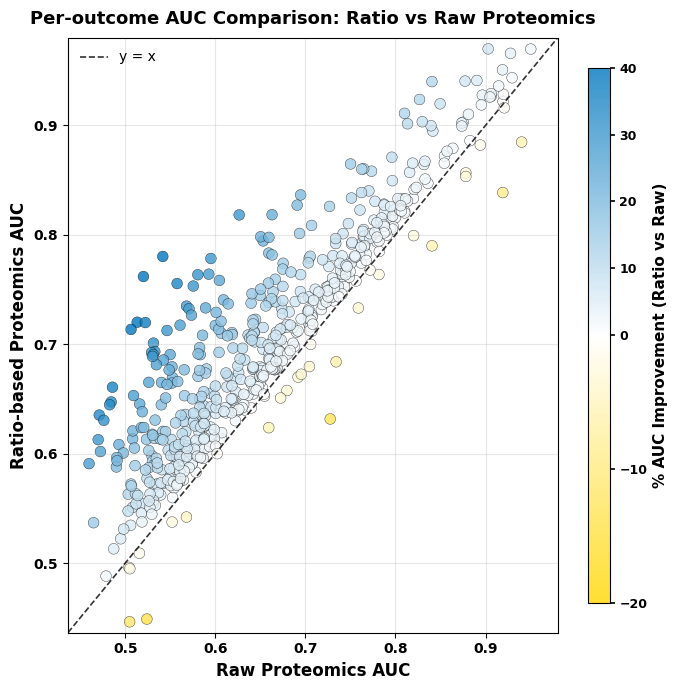

In [10]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# === Collect mean AUCs for all outcomes ===
auc_raw_all = []
auc_ratio_all = []
outcome_ids = []

for outcome in range(n_outcomes):
    if not (all_folds_exist(your_base, outcome, folds) and all_folds_exist(randy_base, outcome, folds)):
        continue

    auc_ratios = get_mean_auc(your_base, outcome, folds)
    auc_raw = get_mean_auc(randy_base, outcome, folds)
    if np.isnan(auc_ratios) or np.isnan(auc_raw):
        continue

    auc_ratio_all.append(auc_ratios)
    auc_raw_all.append(auc_raw)
    outcome_ids.append(outcome)

auc_raw_all = np.array(auc_raw_all)
auc_ratio_all = np.array(auc_ratio_all)
outcome_ids = np.array(outcome_ids)

# === Compute % improvement ===
percent_improvement = np.where(
    auc_raw_all > 0,
    ((auc_ratio_all - auc_raw_all) / auc_raw_all) * 100,
    np.nan
)

# === Define custom diverging colormap ===
colors = ["#FFD700", "#FFFFFF", "#0077BE"]  # gold → white → blue
cmap = mcolors.LinearSegmentedColormap.from_list("percent_auc_cmap", colors)

# Normalize around 0%
norm = mcolors.TwoSlopeNorm(vmin=-20, vcenter=0, vmax=40)

# === Plot ===
plt.figure(figsize=(7, 7))
sc = plt.scatter(
    auc_raw_all,
    auc_ratio_all,
    c=percent_improvement,
    cmap=cmap,
    norm=norm,
    s=60,
    edgecolors="k",
    linewidths=0.3,
    alpha=0.8,
)

# --- Add labels for big improvements ---
highlight_mask = percent_improvement > 100
for i, outcome in enumerate(outcome_ids[highlight_mask]):
    plt.text(
        auc_raw_all[highlight_mask][i] + 0.005,
        auc_ratio_all[highlight_mask][i] + 0.005,
        str(outcome),
        fontsize=9,
        color="black",
        weight="bold",
    )

# --- Equality line ---
lims = [
    min(auc_raw_all.min(), auc_ratio_all.min()) - 0.01,
    max(auc_raw_all.max(), auc_ratio_all.max()) + 0.01
]
plt.plot(lims, lims, "k--", lw=1.2, alpha=0.8, label="y = x")

plt.xlim(lims)
plt.ylim(lims)

# === BOLD axis labels ===
plt.xlabel("Raw Proteomics AUC", fontsize=12, fontweight="bold")
plt.ylabel("Ratio-based Proteomics AUC", fontsize=12, fontweight="bold")

# === BOLD title ===
plt.title("Per-outcome AUC Comparison: Ratio vs Raw Proteomics",
          fontsize=13, fontweight="bold", pad=10)

# === BOLD tick labels ===
plt.xticks(fontsize=10, fontweight="bold")
plt.yticks(fontsize=10, fontweight="bold")

# === Colorbar ===
cbar = plt.colorbar(sc, shrink=0.9, aspect=25)
cbar.set_label("% AUC Improvement (Ratio vs Raw)",
               fontsize=11, fontweight="bold")
cbar.ax.tick_params(labelsize=9, width=1.2)
for t in cbar.ax.get_yticklabels():
    t.set_fontweight("bold")

plt.legend(frameon=False, loc="upper left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()